## A Simple Classification Problem


It is time to handle a different class of problems: classification problems (pun
intended). In a classification problem, we’re trying to predict which class a data
point belongs to.

In [4]:
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc
from plot import *


## Data Generation

Let’s make the data a bit more interesting by using two features (x1 and x2) this
time. We’ll use Scikit-Learn’s make_moons() to generate a toy dataset with 100
data points. We will also add some Gaussian noise and set a random seed to ensure
reproducibility.


In [5]:
X, y = make_moons(n_samples=100, noise=0.3, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=13)

In [6]:
sc = StandardScaler()
sc.fit(X_train)

X_train = sc.transform(X_train)
X_val = sc.transform(X_val)

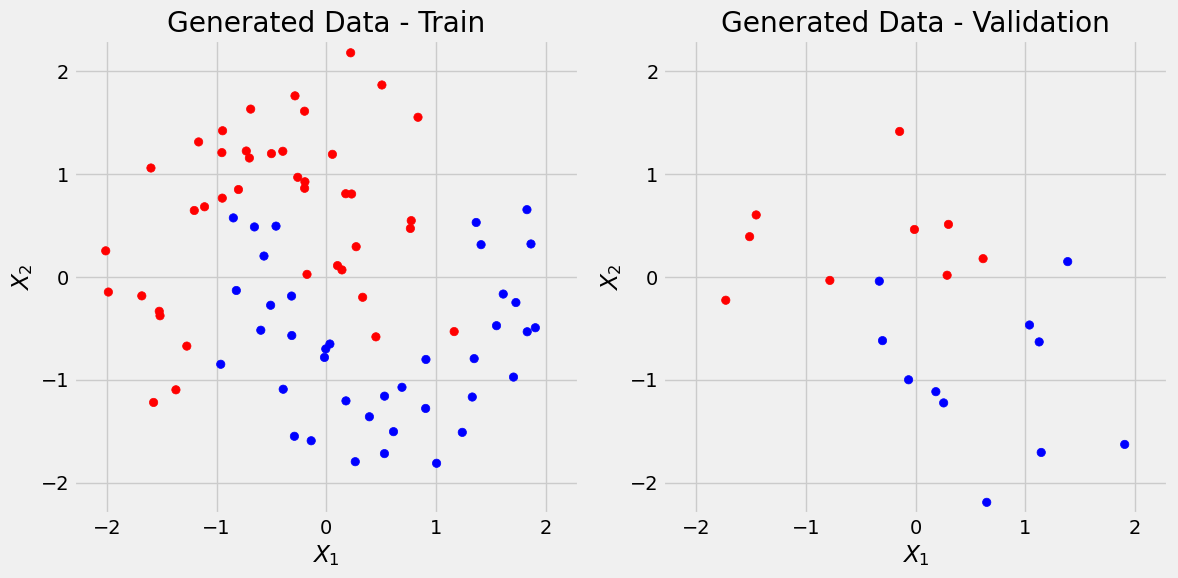

In [7]:
fig = figure1(X_train, y_train, X_val, y_val)

## Data Preparation

the data preparation
step converts Numpy arrays into PyTorch tensors, builds TensorDatasets for them,
and creates the corresponding data loaders.

In [8]:
torch.manual_seed(13)

# Builds tensors from numpy arrays
x_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()

x_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()

# Builds dataset containing ALL data points
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# Builds a loader of each set
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

## Model

### Logistic Regression

Given two features, x1 and x2, the model will fit a linear regression such that its
outputs are logits (z), which are then converted into probabilities using a sigmoid
function.

$$
\Large
\text{P}(y=1) = \sigma(z) = \sigma(b+w_1x_1+w_2x_2)
$$

Given two features, x1 and x2, the model will fit a linear regression such that its
outputs are logits (z), which are then converted into probabilities using a sigmoid
function.

![](images/logistic_model.png)

In [9]:
torch.manual_seed(42)
model1 = nn.Sequential()
model1.add_module('linear', nn.Linear(2, 1))
model1.add_module('sigmoid', nn.Sigmoid())
print(model1.state_dict())

OrderedDict([('linear.weight', tensor([[0.5406, 0.5869]])), ('linear.bias', tensor([-0.1657]))])


## Loss

We already have a model, and now we need to define an appropriate loss for it. A
binary classification problem calls for the binary cross-entropy (BCE) loss,
sometimes known as log loss.

The BCE loss requires the predicted probabilities, as returned by the sigmoid
function, and the true labels (y) for its computation. For each data point i in the
training set, it starts by computing the error corresponding to the point’s true
class.

If the data point belongs to the positive class (y=1), we would like our model to
predict a probability close to one, right? A perfect one would result in the
logarithm of one, which is zero. It makes sense; a perfect prediction means zero
loss. It goes like this:


$$
\Large y_i = 1 \Rightarrow \text{error}_i=\text{log}(\text{P}(y_i=1))
$$

What if the data point belongs to the negative class (y=0)? Then we cannot simply
use the predicted probability. 

Why not? Because the model outputs the probability
of a point’s belonging to the positive, not the negative, class. Luckily, the latter can
be easily computed:


$$
\Large \text{P}(y_i=0)=1-\text{P}(y_i=1)
$$

$$
\Large y_i = 0 \Rightarrow \text{error}_i=\text{log}(1-\text{P}(y_i=1))
$$

Once all errors are computed, they are aggregated into a loss value. For the
binary-cross entropy loss, we simply take the average of the errors and invert its
sign.

$$
\Large
\text{BCE}(y)={-\frac{1}{(N_{\text{pos}}+N_{\text{neg}})}\Bigg[{\sum_{i=1}^{N_{\text{pos}}}{\text{log}(\text{P}(y_i=1))} + \sum_{i=1}^{N_{\text{neg}}}{\text{log}(1 - \text{P}(y_i=1))}}\Bigg]}
$$

### BCELoss

PyTorch implements the binary cross-entropy loss, nn.BCELoss(). Just
like its regression counterpart, nn.MSELoss(), introduced in Chapter 1, it is a higherorder function that returns the actual loss function.

The nn.BCELoss() higher-order function takes two optional arguments (the others
are deprecated, and you can safely ignore them):

• reduction: It takes either mean, sum, or none. The default mean corresponds to
our Equation 3.15 above. As expected, sum will return the sum of the errors,
instead of the average. The last option, none, corresponds to the unreduced
form; that is, it returns the full array of errors.

• weight: The default is none, meaning every data point has equal weight. If
supplied, it needs to be a tensor with a size equal to the number of elements in a
mini-batch, representing the weights assigned to each element in the batch. In
other words, this argument allows you to assign different weights to each
element of the current batch, based on its position. So, the first element would
have a given weight, the second element would have a different weight, and so
on, regardless of the actual class of that particular data point. Sounds
confusing? Weird? Yes, this is weird; I think so too. Of course, this is not useless
or a mistake, but the proper usage of this argument is a more advanced topic
and outside the scope of this book.

 This argument DOES NOT help with weighting imbalanced
datasets! We’ll see how to handle that shortly

In [18]:
loss_fn = nn.BCELoss(reduction='mean')

loss_fn

BCELoss()

### BCEWithLogitsLoss

The former loss function took probabilities as an argument (together with the
labels, obviously). This loss function takes logits as an argument, instead of
probabilities.

It means you should NOT add a sigmoid as the last layer of your model when using
this loss function. This loss combines both the sigmoid layer and the former binary
cross-entropy loss into one.

Now, let’s take a closer look at the nn.BCEWithLogitsLoss() function. It is also a
higher-order function, but it takes three optional arguments (the others are
deprecated, and you can safely ignore them):

• reduction: It takes either mean, sum, or none, and it works just like in
nn.BCELoss(). The default is mean.

• weight: This argument also works just like in nn.BCELoss(), and it is unlikely to
be used.

• pos_weight: The weight of positive samples, it must be a tensor with length
equal to the number of labels associated with a data point (the documentation
refers to classes, instead of labels, which just makes everything even more
confusing).

In [20]:
loss_fn_logits = nn.BCEWithLogitsLoss(reduction='mean')

loss_fn_logits

BCEWithLogitsLoss()

## Model Configuration

In [28]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(2, 1))

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a BCE loss function
loss_fn = nn.BCEWithLogitsLoss()

## Model Training

In [29]:
n_epochs = 100

sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)
sbs.train(n_epochs)

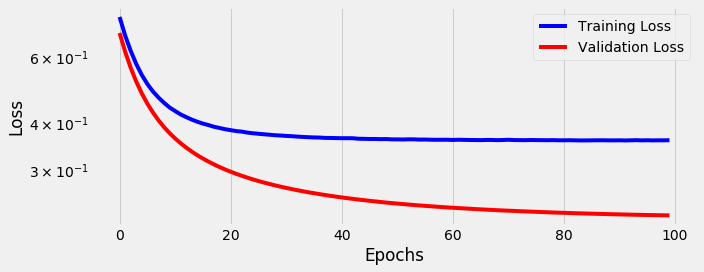

In [30]:
fig = sbs.plot_losses()

In [31]:
print(model.state_dict())

OrderedDict([('linear.weight', tensor([[ 1.1815, -1.8690]])), ('linear.bias', tensor([-0.0581]))])


#### Making Predictions (Logits)

In [32]:
predictions = sbs.predict(x_train_tensor[:4])
predictions

array([[ 0.20252657],
       [ 2.944347  ],
       [ 3.6948545 ],
       [-1.2356305 ]], dtype=float32)

#### Making Predictions (Probabilities)

In [33]:
probabilities = sigmoid(predictions)
probabilities

array([[0.5504593 ],
       [0.94999564],
       [0.9757515 ],
       [0.22519748]], dtype=float32)

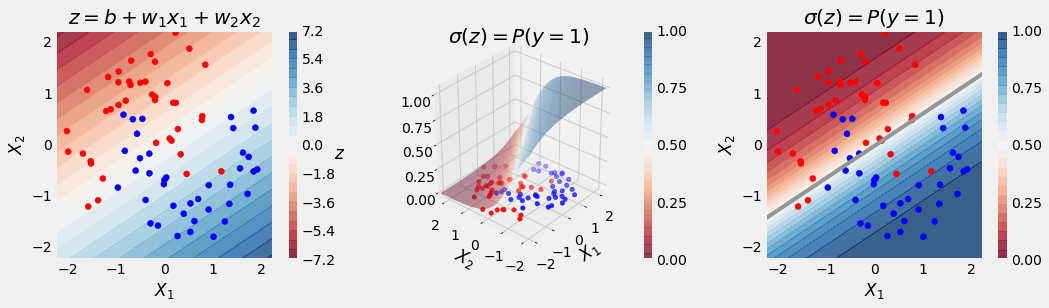

In [35]:
# Training set
fig = figure7(X_train, y_train, sbs.model, sbs.device)